In [ ]:
import os
from functools import partial

from IPython.display import display, clear_output, SVG
import mcubes
import numpy as np
import pydot

import pydrake
from pydrake.all import (
    Adder, AddMultibodyPlantSceneGraph, Box, Cylinder, DiagramBuilder, 
    InverseKinematics, MeshcatVisualizerCpp, MeshcatVisualizerParams,
    Parser, FindResourceOrThrow, PassThrough,
    RigidTransform, RollPitchYaw, RotationMatrix, Simulator, Solve, Sphere,
    ConnectPlanarSceneGraphVisualizer, Demultiplexer, MultibodyPlant, PiecewiseQuaternionSlerp,
    InverseDynamicsController, StateInterpolatorWithDiscreteDerivative, TrajectorySource,
    LeafSystem, BasicVector, JacobianWrtVariable, RollPitchYaw, VectorLogSink, SpatialInertia, UnitInertia, Box, CoulombFriction,
    MathematicalProgram, Solve, eq, le, ge
)
from pydrake.examples.manipulation_station import ManipulationStation
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, MeshcatPoseSliders, AddMeshcatTriad
)
from manipulation.scenarios import (
    AddIiwa, AddPlanarIiwa, AddTwoLinkIiwa, AddWsg, AddShape
)
from manipulation.utils import FindResource
from manipulation import running_as_notebook
from pydrake.trajectories import PiecewisePolynomial
from pydrake.multibody import inverse_kinematics
from pydrake.systems.controllers import PidController
from pydrake.systems.sensors import ImageToLcmImageArrayT
from pydrake.systems.sensors import PixelType
from pydrake.systems.lcm import LcmPublisherSystem
from pydrake.lcm import DrakeLcm
from pydrake.geometry import IllustrationProperties, SourceId, GeometryId, Rgba, PerceptionProperties
from pydrake.geometry.render import RenderLabel, RenderEngineVtkParams, DepthRenderCamera, RenderCameraCore, DepthRange
from pydrake.examples.mesh_painter import MakeRenderEngineVtkWithMaskImages, MeshPainterSystem
import time
import copy
from pydrake.solvers.mathematicalprogram import SolverType

# print(dir(pydrake.systems.sensors))

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

In [ ]:
# Task and Optimization Approach deffinitions and settings for Current Experiment

from enum import Enum

class Task(Enum):
    single_dirt_table = 1
    single_dirt_plate = 2
    multi_dirt_table = 3
    multi_dirt_plate = 4

class Approach(Enum):
    baseline = 0
    strict_constraint = 1
    threshold_constraint = 2
    min_distance_cost = 3

print([task for task in Task])
print([approach for approach in Approach])

CURRENT_TASK = Task.multi_dirt_table
CURRNET_APPROACH = Approach.strict_constraint

NUM_DIRT_PARTICLES = 5

if CURRENT_TASK == Task.single_dirt_table or CURRENT_TASK == Task.single_dirt_plate:
    NUM_DIRT_PATCHES = 1
else:
    # Set if multi task
    NUM_DIRT_PATCHES = 5

[<Task.single_dirt_table: 1>, <Task.single_dirt_plate: 2>, <Task.multi_dirt_table: 3>, <Task.multi_dirt_plate: 4>]
[<Approach.baseline: 0>, <Approach.strict_constraint: 1>, <Approach.threshold_constraint: 2>, <Approach.min_distance_cost: 3>]


In [ ]:
# Function to setup and solve TrajOpt problem to generate wiping locations on table

def create_optimized_wipe_traj(dirt_locs, start_pos, end_pos, n):
    if CURRNET_APPROACH == Approach.baseline:
        traj = [start_pos] + [d for d in dirt_locs] + [end_pos]
        return np.array([xy[0] for xy in traj] + [xy[1] for xy in traj])

    prog = MathematicalProgram()
    #prog.SetSolverOption(SolverType.kSnopt, "Iterations limit", 10000000)

    # Create optimization variables for the x and y positions that we will command the 
    # arm to
    x_locs = prog.NewContinuousVariables(n, "x")
    y_locs = prog.NewContinuousVariables(n, "y")

    if CURRNET_APPROACH == Approach.strict_constraint:
        # Add a squared-distance cost to the points to incentivize the agent to not take a massively 
        # deviating trajectory
        omicron = 1
        threshold = 0.0001
        xy_vel = np.array([[x_locs[i+1] - x_locs[i], y_locs[i+1] - y_locs[i]] for i in range(n-1)])
        prog.AddCost(omicron*np.sum(np.square(xy_vel)))

        def vec_min(x):
            min_distance = x[0]
            for i in range(1, n):
                min_distance = pydrake.math.min(min_distance, x[i])

            return min_distance

        def min_distance_constraint(xy_locs, d_i):
            x_locs = xy_locs[:n]
            y_locs = xy_locs[n:]
            return vec_min([((dirt_locs[d_i,0]-x_locs[i])**2 + (dirt_locs[d_i,1]-y_locs[i])**2) for i in range(n)])


        for d_i in range(dirt_locs.shape[0]):
            def constraint(vars):
                min_distance = min_distance_constraint(vars, d_i)
                return np.array([min_distance])

            prog.AddConstraint(le(constraint(x_locs.tolist() + y_locs.tolist()), threshold))

        # Constrain the solution such that the first and last positions match start_pos and end_pos
        prog.AddConstraint(x_locs[0] == start_pos[0])
        prog.AddConstraint(y_locs[0] == start_pos[1])
        prog.AddConstraint(x_locs[-1] == end_pos[0])
        prog.AddConstraint(y_locs[-1] == end_pos[1])
        prog.AddConstraint(ge(x_locs, np.zeros(n)))
        prog.AddConstraint(le(x_locs, np.ones(n) * 2.0))
        prog.AddConstraint(ge(y_locs, np.ones(n) * -0.7))
        prog.AddConstraint(le(y_locs, np.ones(n) * 0.7))


    elif CURRNET_APPROACH == Approach.threshold_constraint:
        # Add a squared-distance cost to the points to incentivize the agent to not take a massively 
        # deviating trajectory
        omicron = 1
        threshold = 0.0005
        xy_vel = np.array([[x_locs[i+1] - x_locs[i], y_locs[i+1] - y_locs[i]] for i in range(n-1)])
        prog.AddCost(omicron*np.sum(np.square(xy_vel)))

        def vec_min(x):
            min_distance = x[0]
            for i in range(1, n):
                min_distance = pydrake.math.min(min_distance, x[i])

            return min_distance

        def min_distance_constraint(xy_locs, d_i):
            x_locs = xy_locs[:n]
            y_locs = xy_locs[n:]
            return vec_min([((dirt_locs[d_i,0]-x_locs[i])**2 + (dirt_locs[d_i,1]-y_locs[i])**2) for i in range(n)])


        for d_i in range(dirt_locs.shape[0]):
            def constraint(vars):
                min_distance = min_distance_constraint(vars, d_i)
                return np.array([min_distance])

            prog.AddConstraint(le(constraint(x_locs.tolist() + y_locs.tolist()), threshold))

        # Constrain the solution such that the first and last positions match start_pos and end_pos
        prog.AddConstraint(x_locs[0] == start_pos[0])
        prog.AddConstraint(y_locs[0] == start_pos[1])
        prog.AddConstraint(x_locs[-1] == end_pos[0])
        prog.AddConstraint(y_locs[-1] == end_pos[1])
        prog.AddConstraint(ge(x_locs, np.zeros(n)))
        prog.AddConstraint(le(x_locs, np.ones(n) * 2.0))
        prog.AddConstraint(ge(y_locs, np.ones(n) * -0.7))
        prog.AddConstraint(le(y_locs, np.ones(n) * 0.7))

    elif CURRNET_APPROACH == Approach.min_distance_cost:
        # Add a squared-distance cost to the points to incentivize the agent to not take a massively 
        # deviating trajectory
        omicron = 1
        xy_vel = np.array([[x_locs[i+1] - x_locs[i], y_locs[i+1] - y_locs[i]] for i in range(n-1)])
        prog.AddCost(omicron*np.sum(np.square(xy_vel)))

        def vec_min(x):
            min_distance = x[0]
            for i in range(1, n):
                min_distance = pydrake.math.min(min_distance, x[i])

            return min_distance

        def min_distance_cost(xy_locs):
            x_locs = xy_locs[:n]
            y_locs = xy_locs[n:]
            return sum([vec_min([((dirt_locs[j][0]-x_locs[i])**2 + (dirt_locs[j][1]-y_locs[i])**2) for i in range(n)]) for j in range(dirt_locs.shape[0])])


        prog.AddCost(min_distance_cost, vars=x_locs.tolist() + y_locs.tolist())

        # Constrain the solution such that the first and last positions match start_pos and end_pos
        prog.AddConstraint(x_locs[0] == start_pos[0])
        prog.AddConstraint(y_locs[0] == start_pos[1])
        prog.AddConstraint(x_locs[-1] == end_pos[0])
        prog.AddConstraint(y_locs[-1] == end_pos[1])
        prog.AddConstraint(ge(x_locs, np.zeros(n)))
        prog.AddConstraint(le(x_locs, np.ones(n) * 2.0))
        prog.AddConstraint(ge(y_locs, np.ones(n) * -0.7))
        prog.AddConstraint(le(y_locs, np.ones(n) * 0.7))


    prog.SetInitialGuess(x_locs, np.random.rand(n))
    prog.SetInitialGuess(y_locs, np.random.rand(n))
    
    print(prog)
    result = Solve(prog)

    # 6. Get the solution
    if (result.is_success()): 
        sol = result.GetSolution()
        x_sol = sol[0:n]
        y_sol = sol[n:]
        print(f"X Solution: {x_sol}")
        print(f"Y Solution: {y_sol}")
        return sol
    else:
        print("Failed to Solve :(")

Approach.baseline
[array([0.35, 0.  ]), array([0.6, 0.2]), array([ 0.4, -0.2]), array([0.7, 0. ]), array([ 0.6, -0.2]), array([0.4, 0.2]), array([ 0.4, -0.2])]
Approach.strict_constraint
Decision variables:x(0) x(1) x(2) x(3) x(4) x(5) x(6) x(7) x(8) x(9) y(0) y(1) y(2) y(3) y(4) y(5) y(6) y(7) y(8) y(9)

QuadraticCost ((x(0) * (x(0) - x(1))) + (x(1) * ( - x(0) + 2 * x(1) - x(2))) + (x(2) * ( - x(1) + 2 * x(2) - x(3))) + (x(3) * ( - x(2) + 2 * x(3) - x(4))) + (x(4) * ( - x(3) + 2 * x(4) - x(5))) + (x(5) * ( - x(4) + 2 * x(5) - x(6))) + (x(6) * ( - x(5) + 2 * x(6) - x(7))) + (x(7) * ( - x(6) + 2 * x(7) - x(8))) + (x(8) * ( - x(7) + 2 * x(8) - x(9))) + (x(9) * ( - x(8) + x(9))) + (y(0) * (y(0) - y(1))) + (y(1) * ( - y(0) + 2 * y(1) - y(2))) + (y(2) * ( - y(1) + 2 * y(2) - y(3))) + (y(3) * ( - y(2) + 2 * y(3) - y(4))) + (y(4) * ( - y(3) + 2 * y(4) - y(5))) + (y(5) * ( - y(4) + 2 * y(5) - y(6))) + (y(6) * ( - y(5) + 2 * y(6) - y(7))) + (y(7) * ( - y(6) + 2 * y(7) - y(8))) + (y(8) * ( - y(7

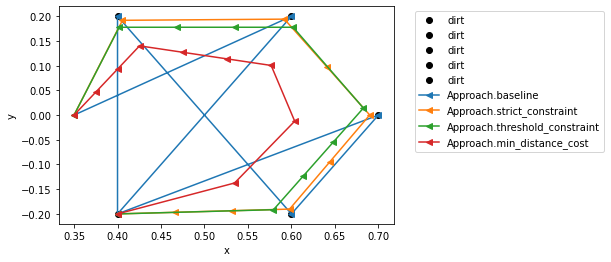

Approach.baseline
[[0.35, 0.0], [0.6, 0.2], [0.4, -0.2], [0.7, 0.0], [0.6, -0.2], [0.4, 0.2], [0.4, -0.2]]
Approach.strict_constraint
[[0.35, 0.0], [0.40567556035393193, 0.19176665206250018], [0.5919008181471239, 0.19413457133858886], [0.6409500080541982, 0.0971607951837487], [0.6900017328796091, 0.0001861575182223994], [0.6439430798669604, -0.09501944956021238], [0.5978844718474501, -0.19022633431280106], [0.531922334980728, -0.19348420397861565], [0.46596118904007255, -0.19674250527982784], [0.4, -0.20000000000000007]]
Approach.threshold_constraint
[[0.35, 0.0], [0.40185974930567864, 0.17771679258720777], [0.4685482396632141, 0.1777183811333624], [0.5352371385786482, 0.17771965462188777], [0.6019245959514274, 0.17772229962256145], [0.6827400799509513, 0.01421601776780411], [0.6482733356383277, -0.05433665264421398], [0.6138066619651913, -0.1228899636999577], [0.5793405599625624, -0.19144502686295436], [0.4, -0.2]]
Approach.min_distance_cost
[[0.35, 0.0], [0.375110434264454, 0.0466960

In [ ]:
# Generates a trajectories for fives dirt locations [(0.6, 0.2), (0.4, -0.2), (0.7, 0.0), (0.6, -0.2), (0.4, 0.2)] using our three constraint optimization formulations
# compared to our naive baseline of wiping each dirt location in order given

import matplotlib.pyplot as plt
np.random.seed(3)

dirt_locs = np.array([[0.6, 0.2], [0.4, -0.2], [0.7, 0.0], [0.6, -0.2], [0.4, 0.2]])
visualization_trajectories = {}

def compute_trajectory(dirt_locs):

    start_pos = [0.35, 0.0]
    end_pos = [0.4, -0.2]
    n = 10
    sol = None
    import time
    start_time = time.time()
    count = 0
    while sol is None:
        try:
            sol = create_optimized_wipe_traj(dirt_locs=dirt_locs, start_pos=start_pos, end_pos=end_pos, n=n)
        except RuntimeError:
            pass
        count += 1
        if count == 100:
            return None, dirt_locs, None, None, None, None
    end_time = time.time()
    des_xypos_list = [np.array([sol[i], sol[int(len(sol)/2)+i]]) for i in range(int(len(sol)/2))]

    return des_xypos_list

for d in dirt_locs:
    plt.plot(d[0],d[1],'ko', label="dirt") 

for approach in Approach:
    print(approach)
    CURRNET_APPROACH = approach
    NUM_DIRT_PARTICLES = 5

    des_xypos_list = compute_trajectory(dirt_locs)

    plt.plot(np.array(des_xypos_list)[:, 0], np.array(des_xypos_list)[:, 1], '<-', label=str(approach))
    print(des_xypos_list)

    visualization_trajectories[approach] = des_xypos_list

plt.xlabel("x")
plt.ylabel("y")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

for approach, traj in visualization_trajectories.items():
    print(approach)
    print([list(point) for point in traj])


In [ ]:
# Evaluates each of our three appraoches and baseline on each task, by generating random dirt locations solving it via our method
# and then stores the percentage of dirt wiped, total squared displacement, and time the solver took to generate the trajectory
# it does this for 1 to 10 dirt locations

def get_controller_trajectory(des_xypos_list):
    controller_trajectory = []
    idx = 0
    pos = des_xypos_list[idx]
    clearance = 0.36 #0.6
    table_z = 0.24 #0.24499465
    wipe_distance = 0.1
    done = False
    command = 0


    for pos in des_xypos_list:
        # [0] GO TO DIRT LOCATION (Pos Control)
        controller_trajectory.append([1, pos[0], pos[1], clearance])

        # [1] DESCENT (Pos Control)
        if True in [(dirt_locs[d_i][0]-pos[0])**2 + (dirt_locs[d_i][1]-pos[1])**2 < 0.001 for d_i in range(dirt_locs.shape[0])]:
            controller_trajectory.append([1, pos[0], pos[1], table_z])

            # [2] WIPE (Force Control)
            # Forward
            controller_trajectory.append([0, pos[0] + wipe_distance, pos[1], clearance])
            # Back
            controller_trajectory.append([0, pos[0], pos[1], clearance ])

            # [3] ASCENT(Pos Control)
            controller_trajectory.append([1, pos[0], pos[1], clearance])

    return controller_trajectory

def get_tot_distance(controller_trajectory):
    return sum([(controller_trajectory[i][1]-controller_trajectory[i+1][1])**2 + (controller_trajectory[i][2]-controller_trajectory[i+1][2])**2 + (controller_trajectory[i][3]-controller_trajectory[i+1][3])**2 for i in range(len(controller_trajectory)-1)])


def get_perc_dirt_reached(dirt_locs, des_xypos_list):
    def vec_min(x):
            min_distance = x[0]
            for i in range(1, len(x)):
                min_distance = pydrake.math.min(min_distance, x[i])

            return min_distance

    def min_distance_constraint(xy_locs, d_i):
        return vec_min([((dirt_locs[d_i][0]-xy_locs[i][0])**2 + (dirt_locs[d_i][1]-xy_locs[i][1])**2) for i in range(len(xy_locs))])

    num_dirt_reached = 0
    for d_i in range(dirt_locs.shape[0]):
        if min_distance_constraint(des_xypos_list, d_i) < 0.001:
            num_dirt_reached += 1

    return (num_dirt_reached/(dirt_locs.shape[0])) * 100

def compute_evaluate_trajectory():
    # Randomly generate dirt locations
    max_x = 0.75
    min_x = 0.35
    max_y = 0.35
    min_y = -0.35

    #
    dirt_locs = np.stack([np.random.uniform(low=min_x, high=max_x, size=NUM_DIRT_PATCHES), np.random.uniform(low=min_y, high=max_y, size=NUM_DIRT_PATCHES)], axis=1)
    #

    start_pos = [0.8, 0.1]
    end_pos = [0.55, 0.0]
    n = 20
    sol = None
    import time
    start_time = time.time()
    count = 0
    while sol is None:
        try:
            sol = create_optimized_wipe_traj(dirt_locs=dirt_locs, start_pos=start_pos, end_pos=end_pos, n=n)
        except RuntimeError:
            pass
        count += 1
        if count == 10:
            return None, dirt_locs, None, None, None, None
    end_time = time.time()
    des_xypos_list = [np.array([sol[i], sol[int(len(sol)/2)+i]]) for i in range(int(len(sol)/2))]

    controller_trajectory = get_controller_trajectory(des_xypos_list)

    print()
    print(CURRENT_TASK)
    print(CURRNET_APPROACH)
    print(NUM_DIRT_PATCHES)
    print(NUM_DIRT_PARTICLES)
    print(controller_trajectory)
    print(dirt_locs)

    # % Dirt Reached
    perc_dirt_reached = get_perc_dirt_reached(dirt_locs, des_xypos_list)
    # Distance Traveled
    tot_distance = get_tot_distance(controller_trajectory)
    # Constraint Solver Time
    solver_time = end_time - start_time
    # Heatmap of Landscape
    heatmap = None

    print()
    print(CURRENT_TASK)
    print(CURRNET_APPROACH)
    print(NUM_DIRT_PATCHES)
    print(NUM_DIRT_PARTICLES)
    print(dirt_locs)

    return controller_trajectory, dirt_locs, perc_dirt_reached, tot_distance, solver_time, heatmap


eval_results = {}

for task in Task:
    for approach in Approach:
        CURRENT_TASK = task
        CURRNET_APPROACH = approach
        NUM_DIRT_PARTICLES = 5

        if CURRENT_TASK == Task.single_dirt_table or CURRENT_TASK == Task.single_dirt_plate:
            NUM_DIRT_PATCHES = 1
            result = compute_evaluate_trajectory()
            eval_results[str(task) + "_" + str(approach) + "_" + str(NUM_DIRT_PATCHES)] = {"controller_trajectory": result[0], "dirt_locs": result[1], "perc_dirt_reached": result[2], "tot_distance": result[3], "solver_time": result[4], "heatmap": result[5]}
        else:
            # Set if multi task
            for i in range(2,10):
                NUM_DIRT_PATCHES = i
                result = compute_evaluate_trajectory()
                eval_results[str(task) + "_" + str(approach) + "_" + str(NUM_DIRT_PATCHES)] = {"controller_trajectory": result[0], "dirt_locs": result[1], "perc_dirt_reached": result[2], "tot_distance": result[3], "solver_time": result[4], "heatmap": result[5]}

print(eval_results)

-inf <= y(11) <= 0.7
-inf <= y(12) <= 0.7
-inf <= y(13) <= 0.7
-inf <= y(14) <= 0.7
-inf <= y(15) <= 0.7
-inf <= y(16) <= 0.7
-inf <= y(17) <= 0.7
-inf <= y(18) <= 0.7
-inf <= y(19) <= 0.7

Failed to Solve :(
Decision variables: x(0)  x(1)  x(2)  x(3)  x(4)  x(5)  x(6)  x(7)  x(8)  x(9) x(10) x(11) x(12) x(13) x(14) x(15) x(16) x(17) x(18) x(19)  y(0)  y(1)  y(2)  y(3)  y(4)  y(5)  y(6)  y(7)  y(8)  y(9) y(10) y(11) y(12) y(13) y(14) y(15) y(16) y(17) y(18) y(19)

QuadraticCost ((x(0) * (x(0) - x(1))) + (x(1) * ( - x(0) + 2 * x(1) - x(2))) + (x(2) * ( - x(1) + 2 * x(2) - x(3))) + (x(3) * ( - x(2) + 2 * x(3) - x(4))) + (x(4) * ( - x(3) + 2 * x(4) - x(5))) + (x(5) * ( - x(4) + 2 * x(5) - x(6))) + (x(6) * ( - x(5) + 2 * x(6) - x(7))) + (x(7) * ( - x(6) + 2 * x(7) - x(8))) + (x(8) * ( - x(7) + 2 * x(8) - x(9))) + (x(9) * ( - x(8) + 2 * x(9) - x(10))) + (x(10) * ( - x(9) + 2 * x(10) - x(11))) + (x(11) * ( - x(10) + 2 * x(11) - x(12))) + (x(12) * ( - x(11) + 2 * x(12) - x(13))) + (x(13) * ( 

KeyboardInterrupt: 

In [ ]:
print(len(eval_results))
for key in eval_results.keys():
    print(key)
    print(eval_results[key]['perc_dirt_reached'])
    print(eval_results[key]['tot_distance'])
    print(eval_results[key]['solver_time'])

72
Task.single_dirt_table_Approach.baseline_1
100.0
0.18593946341891898
2.6464462280273438e-05
Task.single_dirt_table_Approach.strict_constraint_1
100.0
0.13227686799835867
0.08911800384521484
Task.single_dirt_table_Approach.threshold_constraint_1
100.0
0.019598003510827664
0.16357111930847168
Task.single_dirt_table_Approach.min_distance_cost_1
100.0
0.0045926559266174765
0.0570225715637207
Task.single_dirt_plate_Approach.baseline_1
100.0
0.2922027361994076
2.3126602172851562e-05
Task.single_dirt_plate_Approach.strict_constraint_1
None
None
None
Task.single_dirt_plate_Approach.threshold_constraint_1
None
None
None
Task.single_dirt_plate_Approach.min_distance_cost_1
0.0
0.0038157894776165375
0.059412240982055664
Task.multi_dirt_table_Approach.baseline_2
100.0
0.24895538375074966
2.4080276489257812e-05
Task.multi_dirt_table_Approach.baseline_3
100.0
0.23670952221570554
2.193450927734375e-05
Task.multi_dirt_table_Approach.baseline_4
100.0
0.3046299863466134
2.0503997802734375e-05
Task.mul

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e1f7a4de-0698-4427-bcc0-40d4d181e518' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>